In [1]:
cd ../dualnv/

/Users/chuwen/workspace/repair/dualnv


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import pickle as pk
import sys
import time
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap as plc
import pyrp.pydp as py
import pyrp.model as mip
import pyrp.model_sg_alt as subgrad_main
from pyrp import *

plt.rcParams["font.size"] = 9
plt.rcParams["font.weight"] = 400
plt.rcParams["font.family"] = "roboto"
plt.rcParams["font.monospace"] = "roboto mono"
plt.rcParams["lines.linewidth"] = 0.8
plt.rcParams["legend.fontsize"] = "small"
plt.rcParams["text.usetex"] = True

# TEX alias
tex_alias = {'lb': r'$\phi_k$', 'val': r'$\bar z_k$', 'primal_k': r'$z_k$'}

In [139]:
def plot_solution(sol, grayscale=0.99):
  greys = plt.get_cmap('Greys')
  i = [f"{x}" for x in range(sol.shape[0])]
  t = range(sol.shape[1])
  fig, axes = plt.subplots(nrows=len(i))
  axes = [axes] if len(i)==1 else axes
  for idx in range(sol.shape[0]):
    ax = axes[idx]
    isol = sol[idx]
    xsol = isol[:, 1] # solution on X
    for s_id, s in enumerate(['work', 'repair']):
      color = greys(grayscale * isol[:, s_id])
      bar = ax.barh(f"{s}", 1, left=t, height=0.5,
            label=i[idx], color=color)
      bar_children = bar.get_children()
      for idt, bc in enumerate(bar_children):
          if (1 > isol[:, s_id][idt] > 0):
            x, y = bc.get_xy()
            ax.text(x + 0.5, y + 0.25, f"{isol[:, s_id][idt]: .2f}", 
                    ha='center', va='center', color='w')
    ax.xaxis.set_visible(False)
  ax.xaxis.set_visible(True)


  plt.xlabel(r"periods $t$")
  plt.ylabel(r"engines $i$")
  return fig, axes

## Small 1x5

## Small 2x5

In [106]:
np.random.seed(2)
ni = num_i = 2
nt = num_t = 6

In [132]:
# create instance
# problem = create_instance(num_i, num_t, True)
problem = {
  'D': [1.0, 2.0, 2.0, 1.0, 2.0, 1.0],
  'a': [5.0, 3.0],
  'b': [8.0, 7.0],
  'I': ['fl_0', 'fl_1'],
  'T': [0, 1, 2, 3, 4, 5],
  'L': 2,
  'c': np.array([1., 1.]),
  'U': 21,
  'tau': [1, 1],
  's0': [5.0, 5.0],
  'h': np.array([1, 2, 4, 4, 3, 1]),
  'p': np.array([4, 5, 6, 6, 6, 4])
}

In [133]:
kwargs = {  # kwargs
      "i": ni,
      "t": nt,
      "subproblem_alg_name": 'cppdp_batch',
      "mp": False,
      "proc": 0,
      "mp_num": 4,
      "gap": 0.001,
      "scale": nt,
      "max_iteration": 1000,
      "eps_step": 1e-5,
      "log_interval": 20,
      "mip_gap": 0
      # "evals": evals
}
scale = kwargs.get('scale')
num_i = kwargs.get('i')
num_t = kwargs.get('t')
mp_num = kwargs.get('mp_num')
mip_gap = kwargs.get('mip_gap')
bench_lb = {}
bench_sol = {}

r = {}
# plot series
plt_series = []

model, sol, *_ = mip.repair_mip_model(
        problem, engine='gurobi', scale=scale, mp_num=mp_num, gap=mip_gap)

model_relax_u, u_sol, *u_ = mip.repair_mip_model(
    problem,
    engine='gurobi',
    scale=scale,
    mp_num=mp_num,
    gap=mip_gap,
    relax_u=True)

# model_relax_x, *x_ = mip.repair_mip_model(
#     problem,
#     engine='gurobi',
#     scale=scale,
#     mp_num=mp_num,
#     gap=mip_gap,
#     relax_x=True)

Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 36 rows, 42 columns and 104 nonzeros
Model fingerprint: 0x2667245a
Variable types: 18 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 15 rows and 13 columns
Presolve time: 0.00s
Presolved: 21 rows, 29 columns, 64 nonzeros
Variable types: 0 continuous, 29 integer (19 binary)
Found heuristic solution: objective 31.0000000
Found heuristic solut

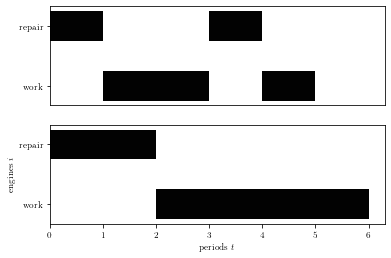

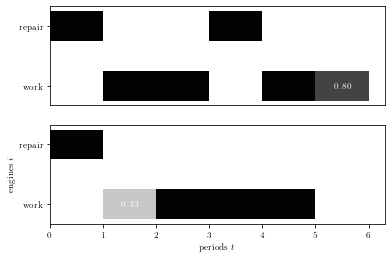

In [140]:
fig, axes = plot_solution(sol)
fig1, axes = plot_solution(u_sol)
fig.savefig(f"/tmp/{ni}x{nt}.png", dpi=500)
fig1.savefig(f"/tmp/{ni}x{nt}_rel.png", dpi=500)

In [96]:
problem

{'D': [2.0, 2.0, 1.0, 1.0, 2.0, 1.0],
 'a': [4.0, 3.0],
 'b': [8.0, 7.0],
 'I': ['fl_0', 'fl_1'],
 'T': [0, 1, 2, 3, 4, 5],
 'L': 2,
 'c': array([1., 1.]),
 'U': 21,
 'tau': [4, 1],
 's0': [5.0, 5.0],
 'h': array([1, 2, 4, 4, 3, 1]),
 'p': array([4, 5, 5, 5, 4, 4])}